# Artwok Image Recognition - Surreal Symphonies
## Import Libraries
   First, we need to import the libraries required for the model's functionality, as well as those needed for tasks like data processing, result visualization, and other related components.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Pre-Trained Models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading and Preprocessing
We start by defining the `data_dir` variable to indicate the directory where the image dataset is stored. Next, we load the dataset using the `tf.keras.preprocessing.image_dataset_from_directory` function. Afterward, we ensure the dataset's integrity by scanning through each folder and removing any corrupted images.

In [4]:
data_dir = '/content/drive/MyDrive/Project/Surreal Symphonies (A dataset of Diverse Artistic Visions)'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 7315 files belonging to 30 classes.


In [5]:
import os
# Iterate through the dataset directory and print the class names
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(class_name)

Romanticism paintings
Neoclassical art
Surrealist paintings
Surrealism artwork
Post-impressionism artwork
Symbolism artwork
Realism paintings
Pre-Raphaelite paintings
Renaissance paintings
Pop art
Expressionism paintings
Fauvism paintings
Na�ve art
Impressionism artwork
Gothic art
Minimalism art
Mannerism paintings
Modernism artwork
Digital art
Neo-expressionism art
Art deco paintings
Baroque paintings
Academic art
Contemporary art
Abstract expressionism paintings
Abstract art
Dadaism artwork
Constructivism art
Cubism art
Art Nouveau paintings


## Data Augmentation and Generator
In this section, we initialize an `ImageDataGenerator` object, `datagen`, for data augmentation. The `datagen` is set up with several augmentation options, including rotation, width and height shifts, shear, zoom, and horizontal flipping. Additionally, the images are rescaled by dividing their pixel values by 255. We then define the image dimensions, batch size, and shape. Lastly, we create distinct data generators for training and validation using the `flow_from_directory` method, which loads images from the specified directory, applies data augmentation, and supplies both the images and their associated labels.

In [6]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

In [7]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [8]:

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Found 5837 images belonging to 30 classes.
Found 1445 images belonging to 30 classes.


In [9]:

num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 30 ....


### Image Visualization

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Define a function to see images
def show_img(data):
    plt.figure(figsize=(15, 15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            try:
                ax.imshow(images[i].numpy().astype("uint8"))
                ax.axis("on")
            except tf.errors.InvalidArgumentError:
                print("Unsupported image file format.")
                break

# Plot the images in the dataset
show_img(data)


Output hidden; open in https://colab.research.google.com to view.

## Training Model - ResNet152V2

This code snippet loads the pre-trained InceptionV3 model, freezes its layers, adds custom layers on top, and compiles the final model.

The pre-trained VGG16 model is imported using `tensorflow.keras.applications` with weights set to `'imagenet'` and the fully connected layers excluded (`include_top=False`). The input shape and pooling type are defined as `img_shape` and `'avg'`, respectively.

The pre-trained model's layers are then frozen by setting their `trainable` attribute to `False`, ensuring the pre-trained weights remain unchanged during training.

Custom layers are added on top of the base model to tailor it for the specific classification task. A batch normalization layer is included to normalize activations, followed by a fully connected layer with 1024 units and ReLU activation. Dropout is applied with a rate of 0.2 to mitigate overfitting. The final dense layer, equipped with `num_classes` units and softmax activation, serves as the output layer for classification.

The complete model is built by defining the pre-trained model's input as the input layer and the predictions from the custom layers as the output layer. The model is compiled using the Adam optimizer with a learning rate of 0.001, `'categorical_crossentropy'` as the loss function for multi-class classification, and `'accuracy'` as the evaluation metric.

Lastly, the model's summary is displayed, presenting the architecture, the output shapes of each layer, and the number of parameters for each component.


In [11]:
# Load pre-trained VGG16
pre_trained =  ResNet152V2(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [12]:
for layer in pre_trained.layers:
    layer.trainable = False
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=pre_trained.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 228, 228, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 234, 234, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 114, 114, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 116, 116, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 57, 57, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 57, 57, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 57, 57, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 57, 57, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 57, 57, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 57, 57, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 59, 59, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 57, 57, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 57, 57, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 57, 57, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 57, 57, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 60,468,766 (230.67 MB)

 Trainable params: 2,133,022 (8.14 MB)

 Non-trainable params: 58,335,744 (222.53 MB)

### Model Training

Train the model using the `fit_generator` method with the training and validation data generators. The method computes the steps per epoch and validation steps, then trains the model over 12 epochs, showing progress and performance metrics during training. The training process details are saved in the `history` variable.

In [13]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=12
)

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 15/183 ━━━━━━━━━━━━━━━━━━━━ 28:30 10s/step - accuracy: 0.1264 - loss: 3.4892

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 2385s 13s/step - accuracy: 0.4666 - loss: 2.1276 - val_accuracy: 0.8228 - val_loss: 0.6324
Epoch 2/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.8410 - loss: 0.5472 - val_accuracy: 0.8976 - val_loss: 0.3986
Epoch 3/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8902 - loss: 0.3732 - val_accuracy: 0.9253 - val_loss: 0.2531
Epoch 4/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9140 - loss: 0.2926 - val_accuracy: 0.9225 - val_loss: 0.3084
Epoch 5/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9216 - loss: 0.2686 - val_accuracy: 0.9384 - val_loss: 0.2283
Epoch 6/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9319 - loss: 0.2333 - val_accuracy: 0.9377 - val_loss: 0.2429
Epoch 7/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9359 - loss: 0.2143 - val_accuracy: 0.9522 - val_loss: 0.1887
Epoch 8/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9425 - loss: 0.1696 - val_accuracy: 0.9

## Plot the Graph
This code visualizes the training and validation loss and accuracy across all epochs. Using the data stored in the `history` object, line plots are generated to display the trends. The x-axis represents the epochs, while the y-axis shows the corresponding loss or accuracy values. Separate plots are created for training and validation metrics, with legends included to distinguish between them.

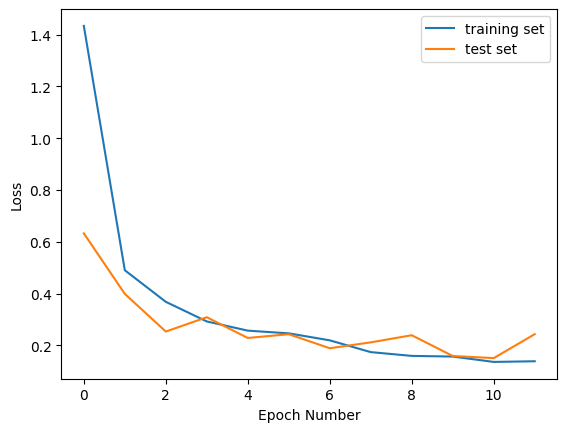

In [14]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

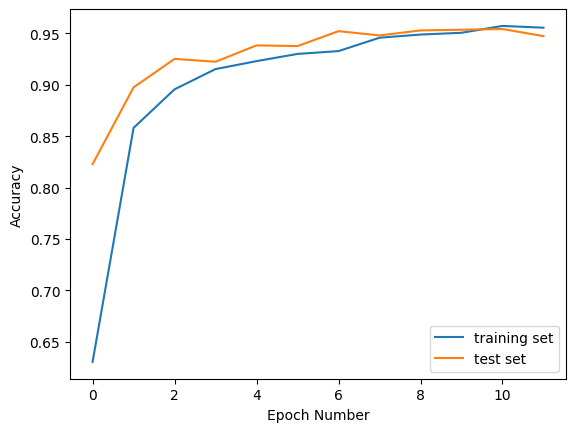

In [15]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### Save the Model


In [16]:
model_name = 'artwork_image_recognition.h5'
model.save(model_name, save_format='h5')

In [17]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

### Image Label and Prediction and Visualization

In [18]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)

    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='green')
    plt.imshow(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


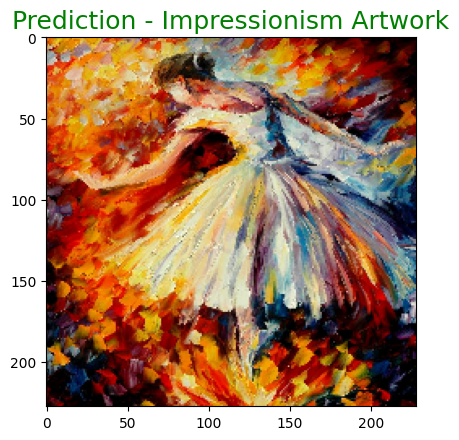

In [19]:
predict_image('/content/drive/MyDrive/Project/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Post-impressionism artwork/Post-impressionism artwork/3a24avbr.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


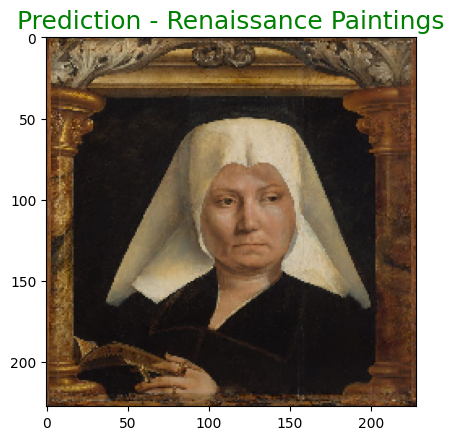

In [20]:
predict_image('/content/drive/MyDrive/Project/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Renaissance paintings/Renaissance paintings/2zp8ik4t.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


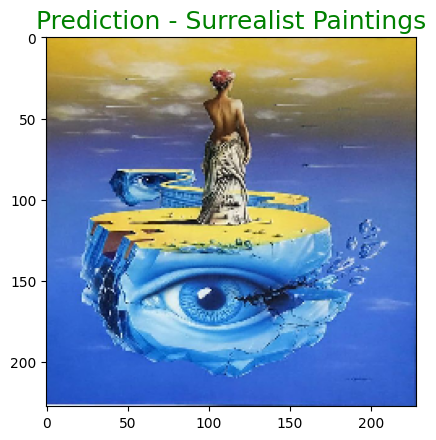

In [21]:
predict_image('/content/drive/MyDrive/Project/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Surrealist paintings/Surrealist paintings/29d29bg4.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


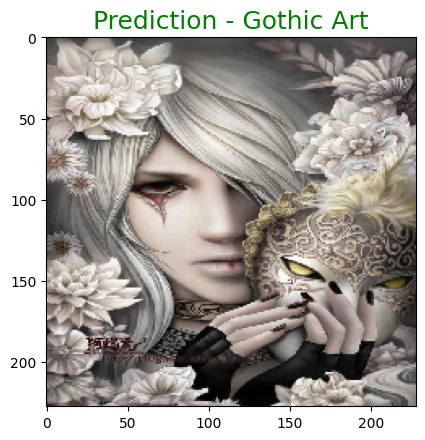

In [22]:
predict_image('/content/drive/MyDrive/Project/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Gothic art/Gothic art/3ufb5wb1.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


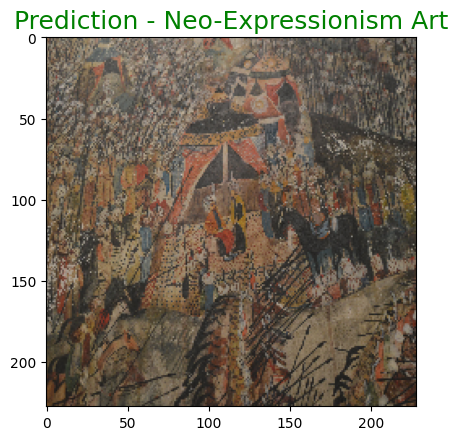

In [23]:
predict_image('/content/drive/MyDrive/Project/Surreal Symphonies (A dataset of Diverse Artistic Visions)/Neo-expressionism art/Neo-expressionism art/14xw8wbv.jpg', model)

### Evaluation

In [24]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Load the saved model
model = tf.keras.models.load_model('artwork_image_recognition.h5')

# Evaluate the model on the original validation data
val_images, val_labels = next(iter(val_data))
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


### F1 score

In [26]:
 # Classification Report
print('Classification Report:')
print(classification_report(val_true_labels, val_pred_labels, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.50      0.50      0.50         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       0.67      0.67      0.67         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       0.50      1.00      0.67         2
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         4
    

### Acuracy Score

In [28]:
# Accuracy Score
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print('Accuracy Score:', accuracy)


Accuracy Score: 0.875


### Confusion Matrix

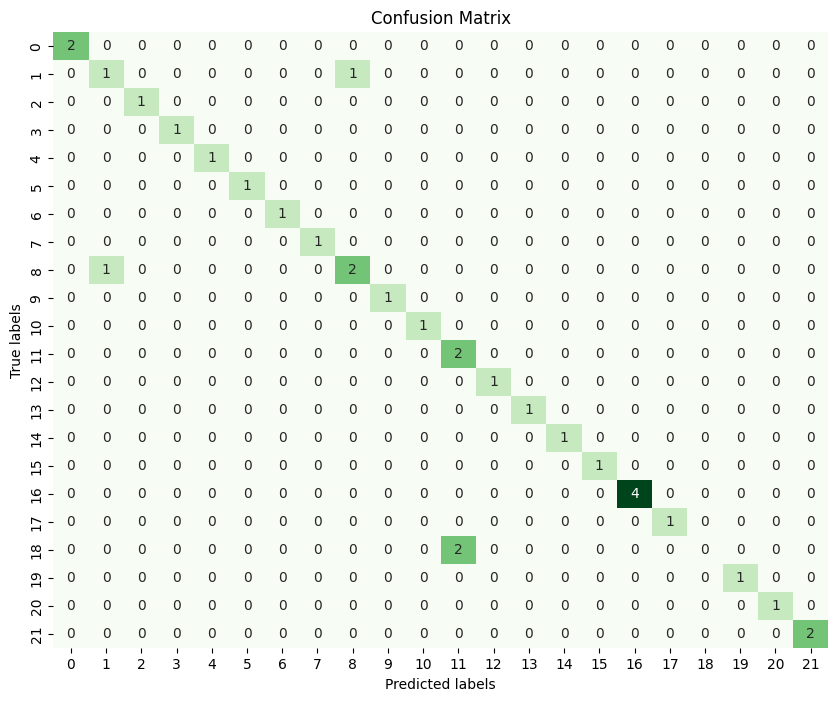

In [29]:
# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Artwork_rec.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Artwork_rec.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 2716133 bytes to /content/drive/MyDrive/Colab Notebooks/Artwork_rec.html
